Some pip install stuff that helped me, you probably won't need the boto3 install if you are running on AWS.

In [1]:
!pip install pyproj
!pip install cartopy
!pip uninstall shapely --y
!pip install shapely --no-binary shapely
!pip install boto3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.3 MB 3.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.8 MB 3.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 38.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 4.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 28.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 12.1 MB 163 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Prepa

The black box guts of the bounding box code are below.  Currently the code can fail or produce an ugly bounded image if band 2 does not exist for the original image or if the lat long is not covered by the original image (GOES 16 vs 17).

In [38]:
import os                                  # Check files
import gc                                  # Clean memory for repeated plots
import requests                            # Read from S3
from datetime import datetime, timedelta   # Datetime handling
from time import time                      # Timing
from json import loads, dumps              # Loading and storing intermediate results

import pandas as pd                        # Load csvs
import boto3                               # AWS S3 access
import matplotlib.pyplot as plt            # Plotting library
import numpy as np                         # Scientific computing with Python
import cartopy, cartopy.crs as ccrs        # Plot maps
from netCDF4 import Dataset                # Read / Write NetCDF4 files
from pyproj import Proj                    # Cartographic projections and coordinate transformations library

goes = 16
bucket = "noaa-goes{}".format(goes) # change if we switch to a different satellite
prefix_base = "ABI-L2-CMIPF" # change if we use a different imaging instrument
aws_access_key_id = "" # fill in with your access id and key
aws_secret_access_key = ""
client = boto3.client('s3', 
                      aws_access_key_id=aws_access_key_id,
                      aws_secret_access_key=aws_secret_access_key)
# for converting to lat lon
default_lats_file = "g{}_lats_8km.txt".format(goes)
default_lons_file = "g{}_lons_8km.txt".format(goes)

def get_image(lat, lon, timestamp, 
              lats_file=default_lats_file, lons_file=default_lons_file,
              ref_grid_resolution_km=8, eyes=True, outfile=None):
  t0 = time()
  url = get_s3_url_for_timestamp(timestamp)
  if url is None:
    raise ValueError("No url found")
  url_time = time() - t0
  print("Acquired URL in {:.3f} seconds\n{}".format(url_time, url))
  save_and_plot_image(url, lat, lon, 
                      lats_file, lons_file, ref_grid_resolution_km, eyes, outfile)


def get_s3_url_for_timestamp(timestamp):
  if "T" in timestamp:
    date, time = timestamp.split("T")
  else:
    date, time = timestamp.split(" ")
  year = date.split("-")[0]
  days = (datetime.strptime(date, "%Y-%m-%d") - datetime.strptime(year, "%Y"))
  days = int(days.days + 1)
  if days < 10:
    days = "00{}".format(days)
  elif days < 100:
    days = "0{}".format(days)
  hour, minute, _ = time.split(":")
  rounded_down_minute = minute[0] + "0"

  addendum = "{year}/{days}/{hour}/OR_ABI-L2-CMIPF-M6C02_G{goes}_s{year}{days}{hour}{minute}".format(
      year=year, days=days, hour=hour, minute=rounded_down_minute, goes=goes
  )

  prefix = "{}/{}".format(prefix_base, addendum)
  result = client.list_objects(Bucket=bucket, Prefix=prefix, Delimiter='/')
  keys = [i["Key"] for i in result.get("Contents", [])]
  if not keys:
    return

  base_url = "https://noaa-goes{}.s3.amazonaws.com".format(goes)
  image = keys[0]
  url = "{}/{}".format(base_url, image)

  return url

def save_and_plot_image(url, lat, lon, 
                        lats_file, lons_file, ref_grid_resolution_km, eyes, outfile):
  t0 = time()
  # Open the GOES-R image
  image = url.split("/")[-1]
  resp = requests.get(url)
  image_file = Dataset(image, memory = resp.content)
  image_file_time = time()
  print("Acquired Image File in {:.3f} seconds".format(image_file_time - t0))
  print(image, lat, lon)
  
  # Get the image resolution
  band_resolution_km = getattr(image_file, 'spatial_resolution')
  band_resolution_km = float(band_resolution_km[:band_resolution_km.find("km")])
  
  deg_delta = 2
  min_lon, max_lon, min_lat, max_lat = lon - deg_delta, lon + deg_delta, lat - deg_delta, lat + deg_delta
  extent = [min_lon, min_lat, max_lon, max_lat]
  
  # Read the GOES-R lat lons as arrays (image_files created previously)
  # NOTE: load outside of for loop to make faster
  if not os.path.exists(lats_file):
    if lats_file == default_lats_file:
      create_default_lats_lons_files()
    else:
      raise Exception("Could not find lats lons files\n{}\n{}".format(lats_file, lons_file))
  lats = np.loadtxt(lats_file)
  lons = np.loadtxt(lons_file)

  # Calculate the lat lon pairs indexes for the desired extent
  idx_pair_1 = abs(lats-extent[1])+abs(lons-extent[0])
  max_lat_idx,min_lon_idx = np.unravel_index(idx_pair_1.argmin(),idx_pair_1.shape)
  idx_pair_2 = abs(lats-extent[3])+abs(lons-extent[2])
  min_lat_idx,max_lon_idx = np.unravel_index(idx_pair_2.argmin(),idx_pair_2.shape)
  
  # Adapt the reference indexes for the current image_file resolution
  min_lat_idx = min_lat_idx * int(ref_grid_resolution_km/band_resolution_km)
  min_lon_idx = min_lon_idx * int(ref_grid_resolution_km/band_resolution_km)
  max_lat_idx = max_lat_idx * int(ref_grid_resolution_km/band_resolution_km)
  max_lon_idx = max_lon_idx * int(ref_grid_resolution_km/band_resolution_km)
  
  # The projection x and y coordinates equals the scanning angle (in radians) multiplied by the satellite height
  sat_h = image_file.variables['goes_imager_projection'].perspective_point_height
  x = image_file.variables['x'][min_lon_idx:max_lon_idx] * sat_h
  y = image_file.variables['y'][min_lat_idx:max_lat_idx] * sat_h
  
  # Get the pixel values
  data = image_file.variables['CMI'][min_lat_idx:max_lat_idx,min_lon_idx:max_lon_idx][::1,::1]
  data_preprocessing_time = time()
  print("Preprocessed Data in {:.3f} seconds".format(data_preprocessing_time - image_file_time))
  
  # Choose the plot size (width x height, in inches)
  plt.figure(figsize=(7,7))

  # Satellite longitude
  sat_lon = image_file.variables['goes_imager_projection'].longitude_of_projection_origin
  # Satellite sweep
  sat_sweep = image_file.variables['goes_imager_projection'].sweep_angle_axis
  
  # Use the Geostationary projection in cartopy
  ax = plt.axes(projection=ccrs.Geostationary(central_longitude=sat_lon, satellite_height=sat_h))
  img_extent = (x.min(), x.max(), y.min(), y.max())
  
  # # Add a shapeimage_file
  # shapeimage_file = list(shpreader.Reader('ne_10m_admin_1_states_provinces.shp').geometries())
  # ax.add_geometries(shapeimage_file, ccrs.PlateCarree(), edgecolor='gold',facecolor='none', linewidth=0.3)
  
  if eyes:
    # Add coastlines, borders and gridlines
    ax.coastlines(resolution='10m', color='white', linewidth=0.8)
    #ax.add_feature(cartopy.feature.BORDERS, edgecolor='gray', linewidth=1.0)
    ax.gridlines(color='white', alpha=0.5, linestyle='--', linewidth=0.5)
    
    # Inserting Labels
    target_lats = [lat]
    target_lons = [lon]
    labels = ["Target"]
    x_offsets = [0.1]
    y_offsets = [0]
    
    ax.plot(target_lons, target_lats, 'bo', color='cyan', markersize=5, transform=ccrs.Geodetic())
    for label, xpt, ypt, x_offset, y_offset in zip(labels, target_lons, target_lats, x_offsets, y_offsets):
      ax.text(xpt+x_offset , ypt+y_offset, label, fontsize=12, fontweight='bold', zorder=8, color='gold', transform=ccrs.Geodetic())

    # Getting the image_file date
    add_seconds = int(image_file.variables['time_bounds'][0])
    date = datetime(2000,1,1,12) + timedelta(seconds=add_seconds)
    date = date.strftime('%d %B %Y %H:%M UTC')
    
    # Add a title
    plt.title('GOES-{} Band 02 (500m)'.format(goes), fontweight='bold', fontsize=10, loc='left')
    plt.title('Sub Region \n' + date, fontsize=10, loc='right')
  else:
    ax.axis("off")
  
  # Plot the image
  img = ax.imshow(data, vmin=0.0, vmax=0.7, extent=img_extent, origin='upper', cmap='gray')
  
  # Save the image
  if outfile is None:
    outfile = '{}__{}_{}.png'.format(image[:-3], lat, lon)
    
  plt.savefig(outfile)
  
  if eyes:
    # Show the image
    plt.show()
  else:
    plt.close("all")
    gc.collect()

  plot_time = time()
  print("Plotted in {:.3f} seconds".format(plot_time - data_preprocessing_time))

def create_default_lats_lons_files():
  # Reference file
  if goes == 16:
    image = "OR_ABI-L2-CMIPF-M6C13_G16_s20192061430442_e20192061440161_c20192061440233.nc"
    image_url = "https://noaa-goes16.s3.amazonaws.com/ABI-L2-CMIPF/2019/206/14/OR_ABI-L2-CMIPF-M6C13_G16_s20192061430442_e20192061440161_c20192061440233.nc"
  else:
    image = "OR_ABI-L2-CMIPF-M6C01_G17_s20192121800341_e20192121809408_c20192121809453.nc"
    image_url = "https://noaa-goes17.s3.amazonaws.com/ABI-L2-CMIPF/2019/212/18/OR_ABI-L2-CMIPF-M6C01_G17_s20192121800341_e20192121809408_c20192121809453.nc"

  resp = requests.get(image_url)

  image_file = Dataset(image, memory = resp.content)

  # Satellite height
  sat_h = image_file.variables['goes_imager_projection'].perspective_point_height
  # Satellite longitude
  sat_lon = image_file.variables['goes_imager_projection'].longitude_of_projection_origin
  # Satellite sweep
  sat_sweep = image_file.variables['goes_imager_projection'].sweep_angle_axis

  # The projection x and y coordinates equals
  # the scanning angle (in radians) multiplied by the satellite height (http://proj4.org/projections/geos.html)
  X = image_file.variables['x'][:][::4] * sat_h
  Y = image_file.variables['y'][:][::4] * sat_h
  # map object with pyproj
  # p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep, a=6378137.0)
  p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)
  # Convert map points to latitude and longitude with the magic provided by Pyproj
  XX, YY = np.meshgrid(X, Y)
  lons, lats = p(XX, YY, inverse=True)
  
  # Pixels outside the globe as -9999
  mask = (lons == lons[0][0])
  lons[mask] = -9999
  lats[mask] = -9999
  
  np.savetxt(default_lats_file, lats, fmt='%.2f')
  np.savetxt(default_lons_file, lons, fmt='%.2f')

  plt.figure(figsize=(12, 12))
  plt.imshow(image_file.variables["CMI"], cmap='gray')
  plt.show()


Test cell below for sanity checks, but the last line shows how to run the black box above.

Acquired URL in 0.227 seconds
https://noaa-goes16.s3.amazonaws.com/ABI-L2-CMIPF/2019/212/18/OR_ABI-L2-CMIPF-M6C02_G16_s20192121800485_e20192121810193_c20192121810278.nc
Acquired Image File in 15.470 seconds
OR_ABI-L2-CMIPF-M6C02_G16_s20192121800485_e20192121810193_c20192121810278.nc 37.8719 -122.2585
Preprocessed Data in 2.290 seconds


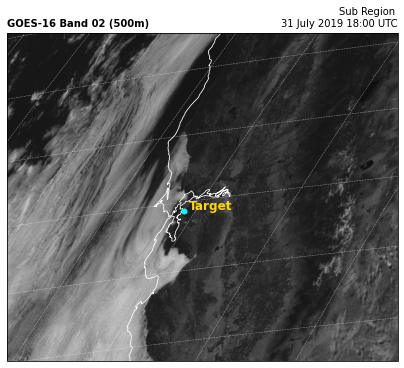

Plotted in 0.581 seconds


In [39]:
# Berkeley
lat = 37.8719
lon = -122.2585
# # New York
# lat = 40.7128
# lon = -74.0060
timestamp = "2019-07-31T18:05:05.0Z"

# # bolide checks
# lat = 17.7
# lon = -148.4
# timestamp = "2021-12-20 16:23:31.000"

get_image(lat, lon, timestamp, eyes=True)

The code below reads the csv with the timestamps and lat longs and runs the bounding box code to save images into the bounding_boxes folder.  

In [43]:
outdir = "bounding_boxes"
if not os.path.exists(outdir):
   os.makedirs(outdir)

df = pd.read_csv("final_bolides.csv")
if os.path.exists("failed.json"):
  with open("failed.json", "r") as f:
    failed = loads(f.read())
else:
  failed = []

processed = []
for i, row in df.iterrows():
  print("\n" + str(i))
  try:
    id = row._id
    lat = row.latitude
    lon = row.longitude
    timestamp = row.datetime
  except AttributeError:
    id = row.potential_bolide_id
    lat = row.potential_bolide_latitude
    lon = row.potential_bolide_longitude
    timestamp = row.potential_bolide_datetime
  
  if id in processed:
    continue
  try:
    get_image(lat, lon, timestamp, outfile="{}/{}.png".format(outdir, id), eyes=False)
  except ValueError:
    print("failed to process {} {} {} {}".format(lat, lon, timestamp, id))
    failed.append((lat, lon, timestamp, id))
    plt.close("all")
    gc.collect()


10457
Acquired URL in 0.202 seconds
https://noaa-goes16.s3.amazonaws.com/ABI-L2-CMIPF/2022/202/01/OR_ABI-L2-CMIPF-M6C02_G16_s20222020110211_e20222020119519_c20222020119588.nc
Acquired Image File in 7.134 seconds
OR_ABI-L2-CMIPF-M6C02_G16_s20222020110211_e20222020119519_c20222020119588.nc 26.352956771850582 177.6643295288086
Preprocessed Data in 2.816 seconds
failed to process 26.352956771850582 177.6643295288086 2022-07-21 01:10:00 1720222020110235001

10458
Acquired URL in 0.249 seconds
https://noaa-goes16.s3.amazonaws.com/ABI-L2-CMIPF/2022/202/08/OR_ABI-L2-CMIPF-M6C02_G16_s20222020810213_e20222020819521_c20222020820004.nc
Acquired Image File in 5.870 seconds
OR_ABI-L2-CMIPF-M6C02_G16_s20222020810213_e20222020819521_c20222020820004.nc 4.120128870010377 -156.33306884765625
Preprocessed Data in 2.111 seconds
Plotted in 0.219 seconds

10459
Acquired URL in 0.164 seconds
https://noaa-goes16.s3.amazonaws.com/ABI-L2-CMIPF/2022/202/16/OR_ABI-L2-CMIPF-M6C02_G16_s20222021610213_e2022202161952

Zip up bounding_boxes folder for download.

In [44]:
!zip -r bounding_boxes.zip bounding_boxes

  adding: bounding_boxes/ (stored 0%)
  adding: bounding_boxes/1720222020811121001.png (deflated 47%)
  adding: bounding_boxes/1720222021909330001.png (deflated 4%)


Write out failures and download bounding_box images and failures through Colab.  Modify/manually download if not running on Colab.

In [45]:
with open("failed.json", "w") as of:
  of.write(dumps(failed))
from google.colab import files
files.download('bounding_boxes.zip')
files.download("failed.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>